TP DE MACHINE LEARNING !!!

C:\Users\mouss\AppData\Local\Temp\ipykernel_9892\967285527.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('WineQT.csv', ',')


      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

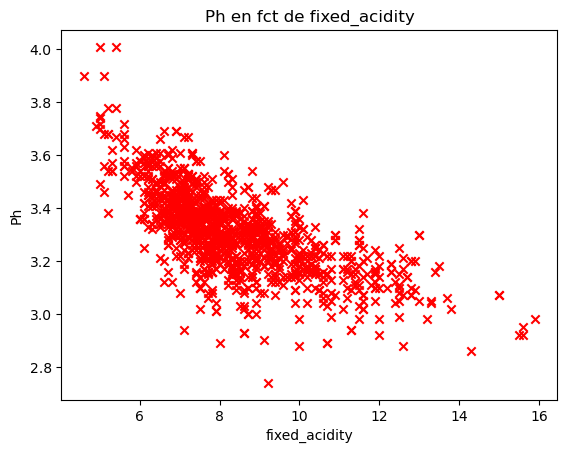

la moyenne d'acidité est de  8.311198600174984


In [3]:
import csv
import pandas as pd

df = pd.read_csv('WineQT.csv', ',')
print(df)
print(df['free sulfur dioxide'])

import numpy as np
import matplotlib.pyplot as plt

# Plot the data points
plt.scatter(df['fixed acidity'], df['pH'], marker='x', c='r')
# Set the title
plt.title("Ph en fct de fixed_acidity")
# Set the y-axis label
plt.ylabel('Ph')
# Set the x-axis label
plt.xlabel('fixed_acidity')
plt.show()
from calculMoyenne import moyenne

print("la moyenne d'acidité est de ",moyenne(df['fixed acidity']))
        

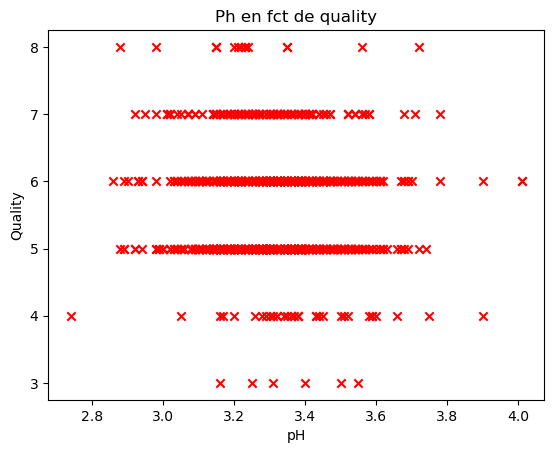

la moyenne d'acidité est de  5.657130358705162


In [4]:
# Plot the data points
plt.scatter(df['pH'], df['quality'], marker='x', c='r')
# Set the title
plt.title("Ph en fct de quality")
# Set the y-axis label
plt.ylabel('Quality')
# Set the x-axis label
plt.xlabel('pH')
plt.show()
from calculMoyenne import moyenne

print("la moyenne d'acidité est de ",moyenne(df['quality']))

Histrogrammes

In [ ]:
for x in df:
    plt.hist(df[x], color='blue', bins='auto')
    plt.title(x)
    plt.show()

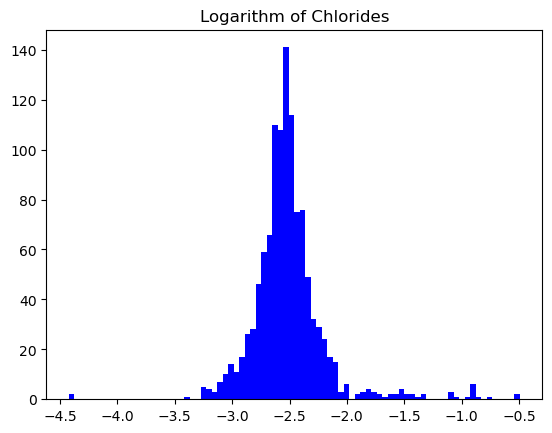

In [36]:
plt.hist(np.log(df['chlorides']), color='blue', bins='auto')
plt.title('Logarithm of Chlorides')
plt.show()

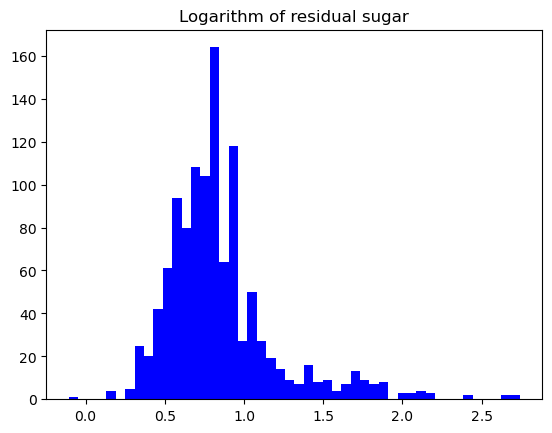

In [37]:
plt.hist(np.log(df['residual sugar']), color='blue', bins='auto')
plt.title('Logarithm of residual sugar')
plt.show()

CORRELATIONS


The correlation DataFrame is:
1.0
fixed acidity
13


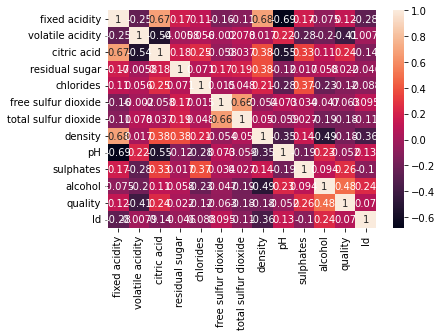

fixed acidity volatile acidity 0.7
fixed acidity residual sugar 1.9
fixed acidity free sulfur dioxide 11.0
fixed acidity total sulfur dioxide 34.0
fixed acidity density 0.9978
fixed acidity pH 3.51
fixed acidity alcohol 9.4
fixed acidity quality 5.0
volatile acidity fixed acidity 7.8
volatile acidity residual sugar 2.6
volatile acidity free sulfur dioxide 25.0
volatile acidity total sulfur dioxide 67.0
volatile acidity density 0.9968
volatile acidity pH 3.2
volatile acidity sulphates 0.68
volatile acidity alcohol 9.8
volatile acidity quality 5.0
volatile acidity Id 1.0
citric acid fixed acidity 7.8
citric acid volatile acidity 0.76
citric acid residual sugar 2.3
citric acid free sulfur dioxide 15.0
citric acid total sulfur dioxide 54.0
citric acid density 0.997
citric acid pH 3.26
citric acid sulphates 0.65
citric acid alcohol 9.8
citric acid quality 5.0
citric acid Id 2.0
residual sugar fixed acidity 11.2
residual sugar free sulfur dioxide 17.0
residual sugar total sulfur dioxide 60.0

IndexError: index 13 is out of bounds for axis 0 with size 13

In [30]:
import seaborn as sns
from dfMethod import dfSeuilValue
corr_df = df.corr()
print("The correlation DataFrame is:")
print(corr_df.iloc[0][0]),
print(corr_df.columns[0])
print(len(corr_df))
   
sns.heatmap(corr_df, annot=True)
plt.show()

dfSeuilValue(0.6,corr_df)